In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def line_repaired_algorithm(binary, candidate_lines, linespacing, λ=0.7, β=0.6):
    max_len = 0
    black_len = {}
    white_len = {}

    # Calculate max black run-length per row
    for i in range(binary.shape[0]):
        row = binary[i, :]
        max_run = 0
        length = 0
        for pix in row:
            if pix == 255:
                length += 1
            else:
                if length > max_run:
                    max_run = length
                length = 0
        if length > max_run:
            max_run = length
        black_len[i] = max_run
        if max_run > max_len:
            max_len = max_run

    # Calculate max white run-length per row
    for i in range(binary.shape[0]):
        row = binary[i, :]
        max_run = 0
        length = 0
        for pix in row:
            if pix == 0:
                length += 1
            else:
                if length > max_run:
                    max_run = length
                length = 0
        if length > max_run:
            max_run = length
        white_len[i] = max_run

    # Step 2: Add rows where black_len > λ * max_len
    lineposition = []
    for i, bl_len in black_len.items():
        if bl_len > λ * max_len:
            lineposition.append(i)

    # Step 3: Remove rows where white_len > β * linespacing
    lineposition = [i for i in lineposition if white_len.get(i, 0) <= β * linespacing]

    # Helper to count lines grouped by spacing (approximate staff line count)
    def count_lines(pos):
        if not pos:
            return 0
        pos = sorted(pos)
        groups = []
        current_group = [pos[0]]
        for p in pos[1:]:
            if p - current_group[-1] <= linespacing * 1.5:
                current_group.append(p)
            else:
                groups.append(current_group)
                current_group = [p]
        groups.append(current_group)
        return len(max(groups, key=len))

    num = count_lines(lineposition)

    # Step 4: Repeat repair until num == 5 or 0
    while num != 5 and num != 0:
        if 2 < num < 5:
            for i, wl_len in white_len.items():
                if wl_len < β * linespacing and i not in lineposition:
                    lineposition.append(i)
                    num += 1
                    if num == 5:
                        break
        elif num < 3:
            if lineposition:
                lineposition.pop()
                num -= 1
        else:
            break

    return sorted(set(lineposition))


Detected staff line positions: 30


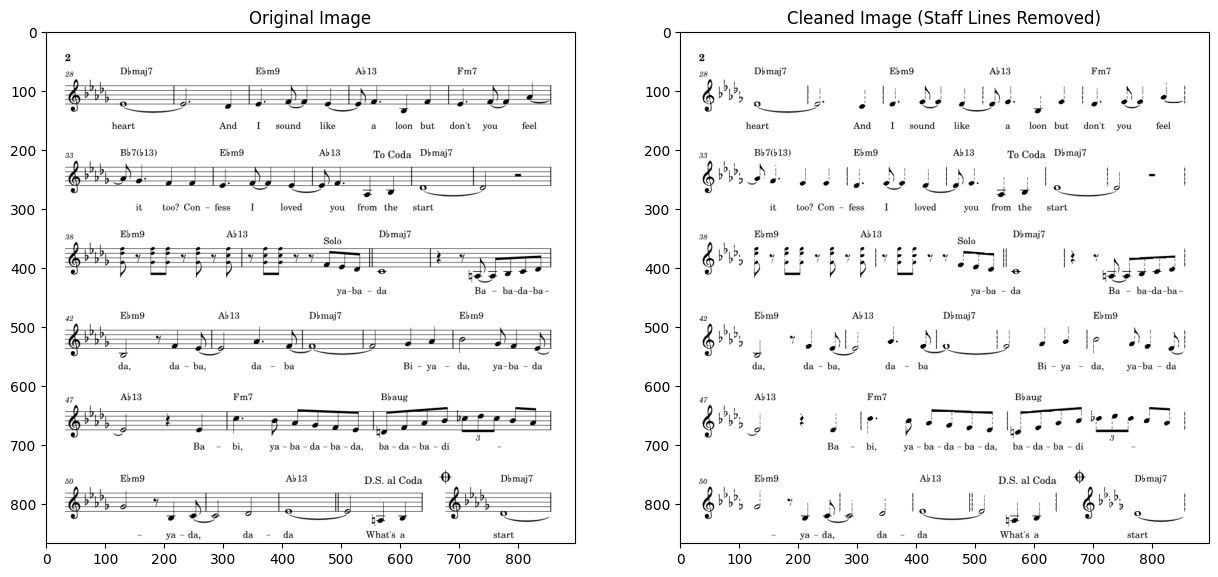

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def process_musical_staff(input_path='test3.png', output_dir='output_steps'):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Step 1: Load and preprocess the image
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Could not load image. Check the file path.")
    
    # Save original image
    plt.imsave(f'{output_dir}/0_original.png', img, cmap='gray')
    
    # Step 2: Adaptive thresholding to handle varying illumination
    binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY_INV, 15, 5)
    plt.imsave(f'{output_dir}/1_binary.png', binary, cmap='gray')
    
    # Step 3: Horizontal projection to find staff line regions
    horizontal_projection = np.sum(binary, axis=1) / 255
    plt.figure(figsize=(10, 5))
    plt.plot(horizontal_projection)
    plt.title('Horizontal Projection')
    plt.savefig(f'{output_dir}/2_horizontal_projection.png')
    plt.close()
    
    # Step 4: Find staff line candidates using projection peaks
    # Smooth the projection to reduce noise
    smoothed_proj = cv2.GaussianBlur(horizontal_projection.astype(np.float32), (3, 3), 0)
    
    # Find peaks in the projection (staff line candidates)
    threshold = 0.2 * np.max(smoothed_proj)
    peaks = np.where(smoothed_proj > threshold)[0]
    
    # Cluster peaks into staff groups
    staff_groups = []
    current_group = [peaks[0]] if len(peaks) > 0 else []
    
    for i in range(1, len(peaks)):
        if peaks[i] - peaks[i-1] < 15:  # Lines in a staff are close together
            current_group.append(peaks[i])
        else:
            if len(current_group) >= 3:  # Minimum 3 lines to consider a staff
                staff_groups.append(current_group)
            current_group = [peaks[i]]
    
    if len(current_group) >= 3:
        staff_groups.append(current_group)
    
    # Step 5: Refine staff line detection
    refined_staff_lines = []
    for group in staff_groups:
        # For each candidate line in the group, find the exact position
        staff_lines = []
        for y in group:
            # Look at a horizontal slice around the candidate line
            slice_height = 5
            roi = binary[max(0, y-slice_height):min(binary.shape[0], y+slice_height+1), :]
            
            # Find the row with maximum black pixels in this slice
            row_sums = np.sum(roi, axis=1) / 255
            exact_y = np.argmax(row_sums) + max(0, y-slice_height)
            staff_lines.append(exact_y)
        
        # Sort and remove duplicates
        staff_lines = sorted(list(set(staff_lines)))
        
        # Only keep groups that form a proper staff (4-6 lines, regular spacing)
        if 4 <= len(staff_lines) <= 6:
            # Check if spacing is regular
            spacings = np.diff(staff_lines)
            if np.std(spacings) < 3:  # Spacing should be fairly consistent
                refined_staff_lines.extend(staff_lines)
    
    # Step 6: Visualize detected staff lines
    line_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for y in refined_staff_lines:
        cv2.line(line_img, (0, y), (img.shape[1]-1, y), (0, 255, 0), 1)
    plt.imsave(f'{output_dir}/3_detected_lines.png', line_img)
    
    # Step 7: Staff line removal
    # Create a mask for staff lines (we'll dilate to cover the full thickness)
    line_mask = np.zeros_like(binary)
    for y in refined_staff_lines:
        line_mask[y, :] = 255
    
    # Dilate the mask to cover the full line thickness
    kernel = np.ones((3, 3), np.uint8)
    line_mask = cv2.dilate(line_mask, kernel, iterations=1)
    plt.imsave(f'{output_dir}/4_line_mask.png', line_mask, cmap='gray')
    
    cleaned_img = img.copy()
    cleaned_img[line_mask == 255] = 255

    # Save the image with staff lines removed first
    plt.imsave(f'{output_dir}/5_cleaned_image.png', cleaned_img, cmap='gray')

    # Step 6: Redraw erased notes
    final_output = cleaned_img.copy()
    cv2.imwrite('output_steps/6_final_cleaned.png', final_output)
    return refined_staff_lines, final_output

if __name__ == "__main__":
    line_positions, cleaned_image = process_musical_staff()
    print("Detected staff line positions:", len(line_positions))
    
    # Display results
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread('test3.png', cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cleaned_image, cmap='gray')
    plt.title('Cleaned Image (Staff Lines Removed)')
    plt.show()

Detected staff line positions: 30


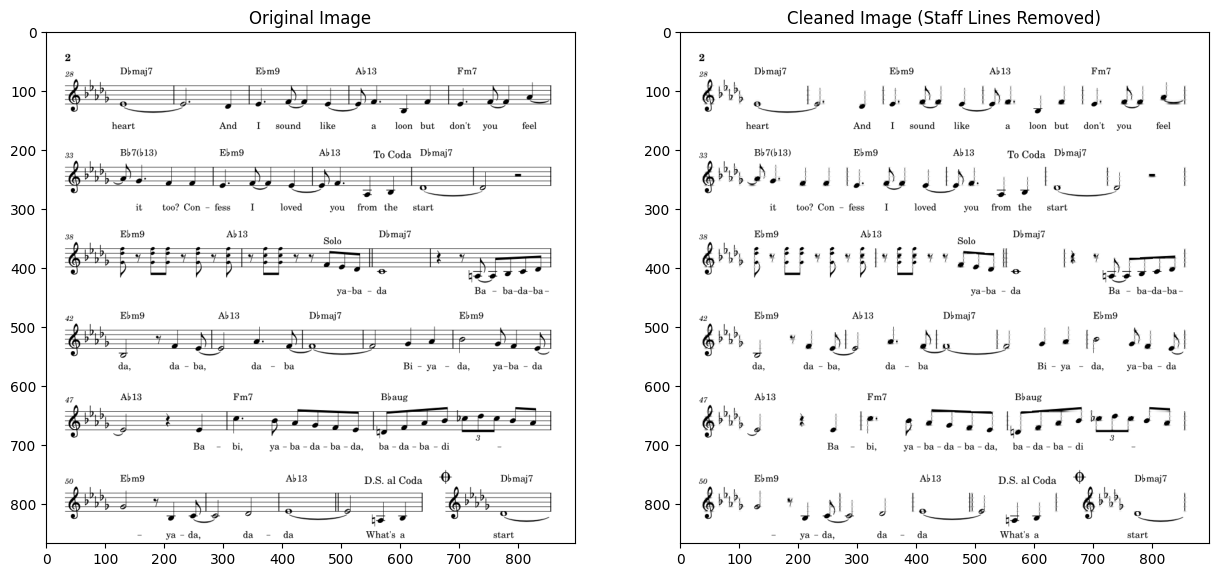

In [160]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def process_musical_staff(input_path='test3.png', output_dir='output_steps'):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Step 1: Load and preprocess the image
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Could not load image. Check the file path.")
    
    # Save original image
    plt.imsave(f'{output_dir}/0_original.png', img, cmap='gray')
    
    # Step 2: Adaptive thresholding to handle varying illumination
    binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY_INV, 15, 5)
    plt.imsave(f'{output_dir}/1_binary.png', binary, cmap='gray')
    
    # Step 3: Horizontal projection to find staff line regions
    horizontal_projection = np.sum(binary, axis=1) / 255
    plt.figure(figsize=(10, 5))
    plt.plot(horizontal_projection)
    plt.title('Horizontal Projection')
    plt.savefig(f'{output_dir}/2_horizontal_projection.png')
    plt.close()
    
    # Step 4: Find staff line candidates using projection peaks
    # Smooth the projection to reduce noise
    smoothed_proj = cv2.GaussianBlur(horizontal_projection.astype(np.float32), (3, 3), 0)
    
    # Find peaks in the projection (staff line candidates)
    threshold = 0.2 * np.max(smoothed_proj)
    peaks = np.where(smoothed_proj > threshold)[0]
    
    # Cluster peaks into staff groups
    staff_groups = []
    current_group = [peaks[0]] if len(peaks) > 0 else []
    
    for i in range(1, len(peaks)):
        if peaks[i] - peaks[i-1] < 15:  # Lines in a staff are close together
            current_group.append(peaks[i])
        else:
            if len(current_group) >= 3:  # Minimum 3 lines to consider a staff
                staff_groups.append(current_group)
            current_group = [peaks[i]]
    
    if len(current_group) >= 3:
        staff_groups.append(current_group)
    
    # Step 5: Refine staff line detection
    refined_staff_lines = []
    for group in staff_groups:
        # For each candidate line in the group, find the exact position
        staff_lines = []
        for y in group:
            # Look at a horizontal slice around the candidate line
            slice_height = 5
            roi = binary[max(0, y-slice_height):min(binary.shape[0], y+slice_height+1), :]
            
            # Find the row with maximum black pixels in this slice
            row_sums = np.sum(roi, axis=1) / 255
            exact_y = np.argmax(row_sums) + max(0, y-slice_height)
            staff_lines.append(exact_y)
        
        # Sort and remove duplicates
        staff_lines = sorted(list(set(staff_lines)))
        
        # Only keep groups that form a proper staff (4-6 lines, regular spacing)
        if 4 <= len(staff_lines) <= 6:
            # Check if spacing is regular
            spacings = np.diff(staff_lines)
            if np.std(spacings) < 3:  # Spacing should be fairly consistent
                refined_staff_lines.extend(staff_lines)
    
    # Step 6: Visualize detected staff lines
    line_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for y in refined_staff_lines:
        cv2.line(line_img, (0, y), (img.shape[1]-1, y), (0, 255, 0), 1)
    plt.imsave(f'{output_dir}/3_detected_lines.png', line_img)
    
    # Step 7: Staff line removal and note restoration using inpainting
    line_mask = np.zeros_like(img)
    for y in refined_staff_lines:
        line_mask[y, :] = 255

    # Dilate the mask to cover the full line thickness
    kernel = np.ones((3, 3), np.uint8)
    line_mask = cv2.dilate(line_mask, kernel, iterations=1)
    plt.imsave(f'{output_dir}/4_line_mask.png', line_mask, cmap='gray')

    cleaned_img = img.copy()
    cleaned_img[line_mask == 255] = 255

    # Save the image with staff lines removed first
    plt.imsave(f'{output_dir}/5_cleaned_image.png', cleaned_img, cmap='gray')
    
    # Step 8: Redraw erased notes
    erased_mask = (img < 20) & (line_mask > 50) & (cleaned_img > img)

    erased_parts = np.ones_like(img, dtype=np.uint8) * 255 
    erased_parts[erased_mask] = img[erased_mask]            # Show only erased note fragments

    # Invert the image: background becomes black, notes become white
    erased_parts_inverted = 255 - erased_parts

    # If you want a 3-channel image (optional, for color consistency)
    erased_parts_inverted = cv2.cvtColor(erased_parts_inverted, cv2.COLOR_GRAY2BGR)

    plt.imsave(f'{output_dir}/5b_erased_note_parts.png', erased_parts_inverted, cmap='gray')

    # Inpaint the staff lines in the ORIGINAL grayscale image
    inpainted = cv2.inpaint(img, line_mask, 3, cv2.INPAINT_TELEA)

    # Restore black pixels from the original where the original was much darker than the inpainted result
    # (i.e., where a note or symbol overlapped a staff line)
    final_output = inpainted.copy()
    mask_restore = (img < 20) & (line_mask > 0)
    final_output[mask_restore] = img[mask_restore]

    cv2.imwrite(f'{output_dir}/6_final_cleaned.png', final_output)
    return refined_staff_lines, final_output

if __name__ == "__main__":
    line_positions, cleaned_image = process_musical_staff()
    print("Detected staff line positions:", len(line_positions))
    
    # Display results
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread('test3.png', cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cleaned_image, cmap='gray', vmin=0, vmax=255)
    plt.title('Cleaned Image (Staff Lines Removed)')
    plt.show()